In [29]:
import local_models.local_models
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import logging
import ml_battery.log
import time
import os
import functools
import collections
import itertools
import pymongo
import datetime
import pytz
import pandas as pd
import local_models.loggin
import re

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
DATETIME_FORMAT = "%a %b %d %H:%M:%S %z %Y"
def strptime(dt): return datetime.datetime.strptime(dt, DATETIME_FORMAT)
def strftime(dt): return dt.strftime(DATETIME_FORMAT)

In [4]:
RUN = 1
BANDWIDTH = 0.35
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
root_dir = "/home/scott/local_w2v/"
project_dir = os.path.join(root_dir, "r{:03d}_k{}".format(RUN, KERNEL(bandwidth=BANDWIDTH)))
data_dir = os.path.join(root_dir, "data")
os.makedirs(project_dir, exist_ok=1)

In [5]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [6]:
db = client["twitter_database"]

In [7]:
print(db.list_collection_names())

['blah', 'system.indexes', 'mobile_mardi_gras', 'christchurch_shooting', 'poway_shooting', 'shuri_castle_fire', 'elpaso_shooting', 'highlands_ranch_shooting', 'dayton_ohio_shooting', 'test', 'jefferson_tornadoes', 'notre_dame_burning', 'odessa_shooting', 'kansascity_tornadoes', 'colombo_bombing', 'gilroy_shootings', 'virginia_beach_shooting', 'guadalajara_hail']


In [8]:
data_collections = [
    'christchurch_shooting', 
    'notre_dame_burning', 
    'colombo_bombing', 
    'poway_shooting', 
    'highlands_ranch_shooting', 
    'jefferson_tornadoes', 
    'kansascity_tornadoes', 
    'virginia_beach_shooting', 
    'guadalajara_hail', 
    'gilroy_shootings', 
    'elpaso_shooting', 
    'dayton_ohio_shooting', 
    'odessa_shooting', 
    'shuri_castle_fire']

In [9]:
ground_truth_labels = list(itertools.starmap(datetime.datetime, 
    [
        (2019, 3, 15, 13, 40, 0, 0, pytz.timezone("Pacific/Auckland")),
        (2019, 4, 15, 18, 20, 0, 0, pytz.timezone("Europe/Paris")),
        (2019, 4, 21, 8, 25, 0, 0, pytz.timezone("Asia/Colombo")),
        (2019, 4, 27, 11, 20, 0, 0, pytz.timezone("America/Los_Angeles")),
        (2019, 5, 7, 13, 50, 0, 0, pytz.timezone("America/Denver")),
        (2019, 5, 22, 23, 40, 0, 0, pytz.timezone("America/Chicago")),
        (2019, 5, 28, 23, 0, 0, 0, pytz.utc),
        (2019, 5, 31, 16, 20, 0, 0, pytz.timezone("America/New_York")),
        (2019, 6, 30, 1, 0, 0, 0, pytz.timezone("America/Mexico_City")),
        (2019, 7, 28, 17, 40, 0, 0, pytz.timezone("America/Los_Angeles")),
        (2019, 8, 3, 10, 40, 0, 0, pytz.timezone("America/Denver")),
        (2019, 8, 4, 13, 0, 0, 0, pytz.timezone("America/New_York")),
        (2019, 8, 31, 15, 20, 0, 0, pytz.timezone("America/Chicago")),
        (2019, 10, 31, 2, 30, 0, 0, pytz.timezone("Asia/Tokyo")),
    ]))

In [10]:
list(db[data_collections[0]].find({"retweeted_status":{"$exists":False}}).limit(10))

[{'_id': ObjectId('5c8bb113dd0697573eb1cfd1'),
  'created_at': 'Thu Mar 07 23:57:23 +0000 2019',
  'hashtags': [],
  'id': 1103806883918303233,
  'id_str': '1103806883918303233',
  'in_reply_to_screen_name': 'beckeleven',
  'in_reply_to_status_id': 1103804165849985024,
  'in_reply_to_user_id': 96954044,
  'lang': 'en',
  'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
  'text': '@beckeleven It would seem a shame to buck tradition.',
  'urls': [],
  'user': {'created_at': 'Tue Nov 13 00:15:11 +0000 2012',
   'description': 'Sociologist. UC Lecturer. Independent researcher. Firefighter. NZ Herald columnist. Author of Patched. Ed of Criminal Justice. New book out in March.',
   'favourites_count': 31250,
   'followers_count': 4434,
   'friends_count': 320,
   'id': 944867864,
   'id_str': '944867864',
   'lang': 'en',
   'listed_count': 58,
   'location': 'Christchurch, NZ',
   'name': 'Jarrod Gilbert',
   'profile_background_color': '000000',
   'profile_b

In [11]:
dates = []
for coll in data_collections:
    first = strptime(
        list(db[coll].find().sort([("id_str", pymongo.ASCENDING)]).limit(1))[0]['created_at'])
    last = strptime(
        list(db[coll].find().sort([("id_str", pymongo.DESCENDING)]).limit(1))[0]['created_at'])
    dates.append((first, last))

In [12]:
dates

[(datetime.datetime(2019, 3, 7, 23, 6, 41, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 3, 15, 22, 40, 49, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 4, 7, 23, 59, 39, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 4, 22, 23, 56, 43, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 4, 14, 22, 5, 21, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 4, 25, 5, 13, 3, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 4, 20, 23, 9, 35, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 4, 30, 21, 1, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 4, 30, 23, 43, 17, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 5, 8, 20, 6, 31, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 5, 15, 23, 11, 54, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 5, 24, 0, 15, 2, tzinfo=datetime.timezone.utc)),
 (datetime.datetime(2019, 5, 21, 23, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2019, 

In [13]:
for i in range(len(dates)):
    date_pair = dates[i]
    coll = data_collections[i]
    print(coll, " :: ", date_pair[1] - date_pair[0], " :: ", db[coll].count(), " :: ", db[coll].find({"retweeted_status":{"$exists":False}}).count())

christchurch_shooting  ::  7 days, 23:34:08  ::  23543  ::  17569
notre_dame_burning  ::  14 days, 23:57:04  ::  543868  ::  243315
colombo_bombing  ::  10 days, 7:07:42  ::  89011  ::  37440
poway_shooting  ::  9 days, 21:51:25  ::  27787  ::  22158
highlands_ranch_shooting  ::  7 days, 20:23:14  ::  49420  ::  40905
jefferson_tornadoes  ::  8 days, 1:03:08  ::  17842  ::  10463
kansascity_tornadoes  ::  8 days, 5:44:11  ::  456492  ::  287430
virginia_beach_shooting  ::  7 days, 18:24:18  ::  97963  ::  73365
guadalajara_hail  ::  8 days, 3:09:11  ::  588305  ::  398363
gilroy_shootings  ::  7 days, 18:53:05  ::  23478  ::  8195
elpaso_shooting  ::  23 days, 20:02:45  ::  697692  ::  195852
dayton_ohio_shooting  ::  24 days, 1:17:16  ::  212192  ::  126175
odessa_shooting  ::  7 days, 18:52:12  ::  60352  ::  25466
shuri_castle_fire  ::  8 days, 3:04:24  ::  170575  ::  101898


In [14]:
coll_dates = []
for coll in data_collections:
    coll_dates.append(list(map(strptime,
        (tweet['created_at'] for tweet in db[coll].find({"retweeted_status":{"$exists":False}}, projection=['created_at'])))))

In [15]:
coll_dates[0][0], coll_dates[0][0].timestamp(), datetime.datetime.fromtimestamp(coll_dates[0][0].timestamp())

(datetime.datetime(2019, 3, 7, 23, 57, 23, tzinfo=datetime.timezone.utc),
 1552003043.0,
 datetime.datetime(2019, 3, 7, 17, 57, 23))

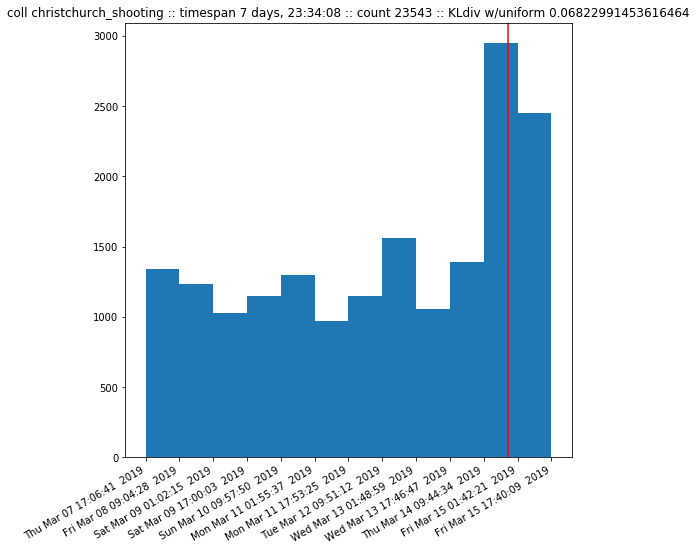

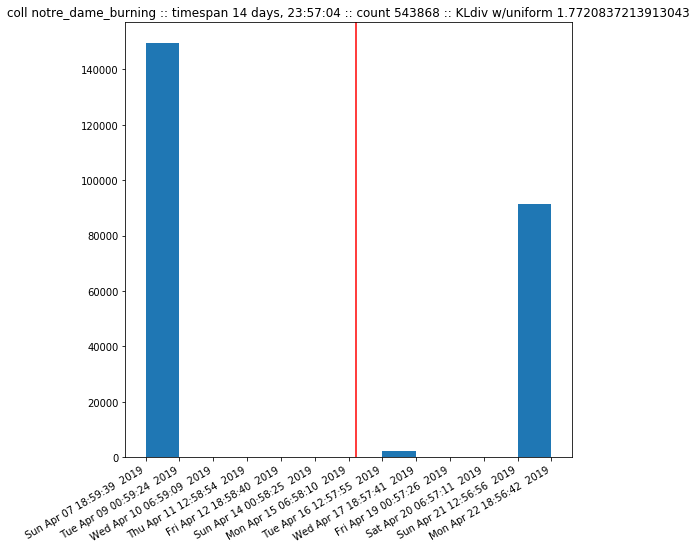

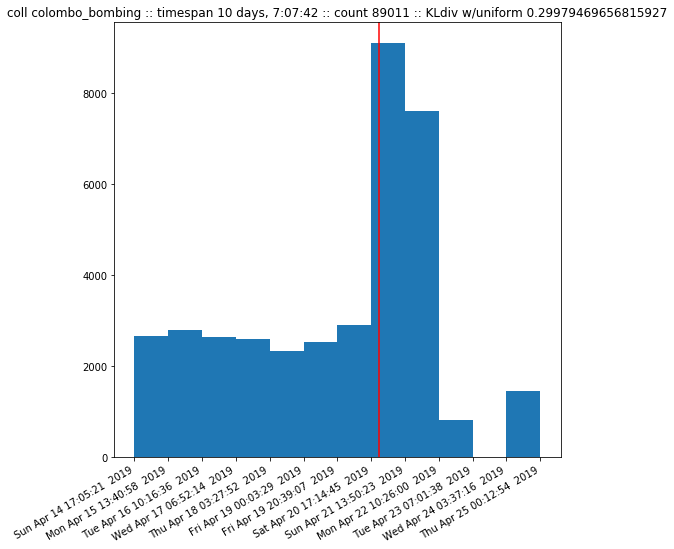

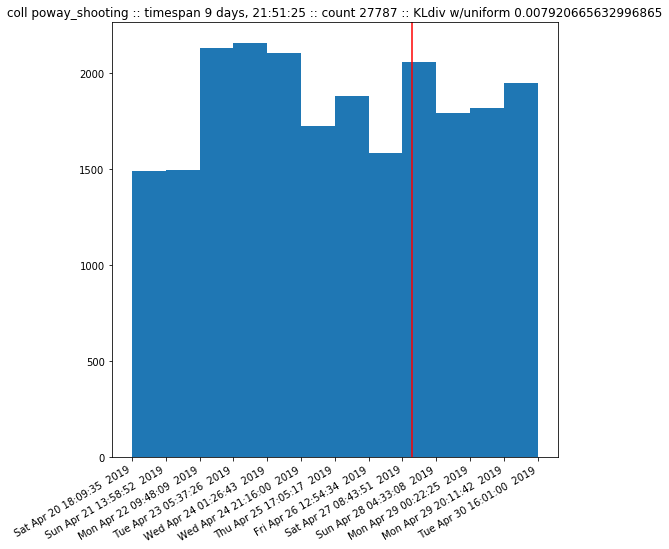

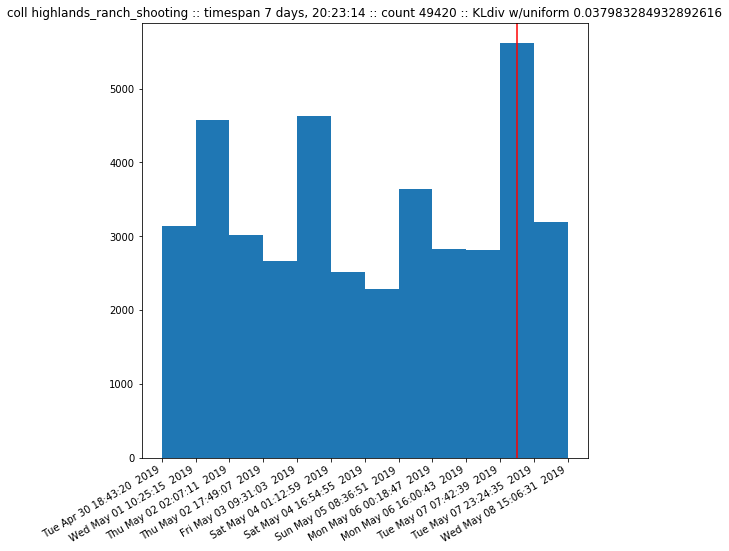

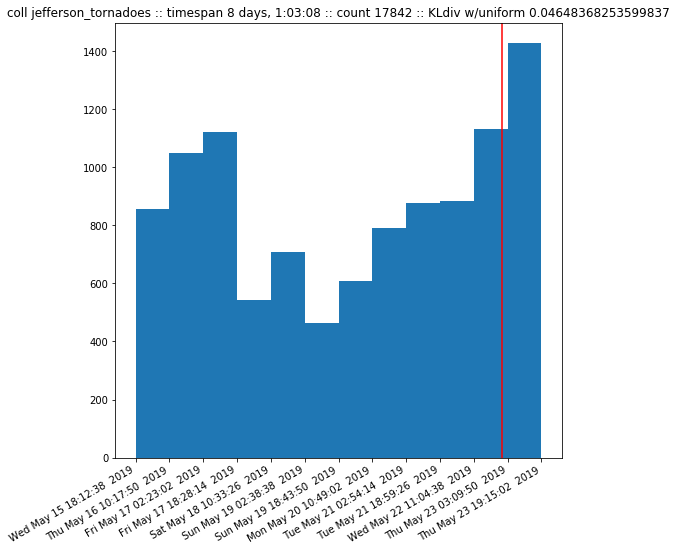

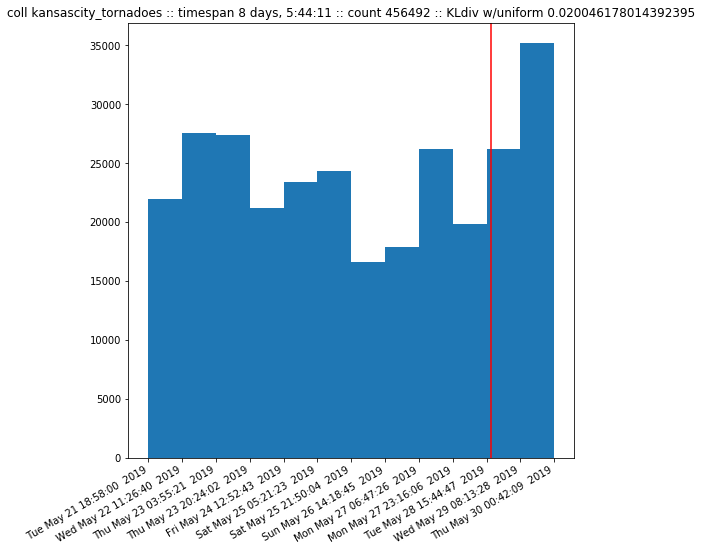

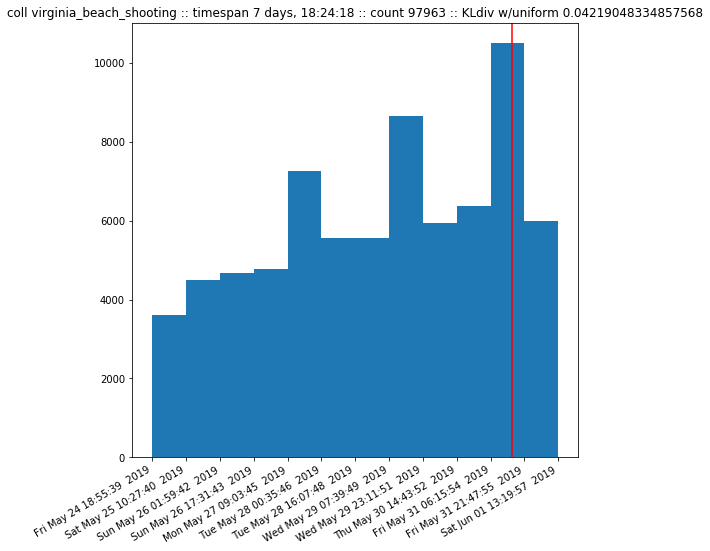

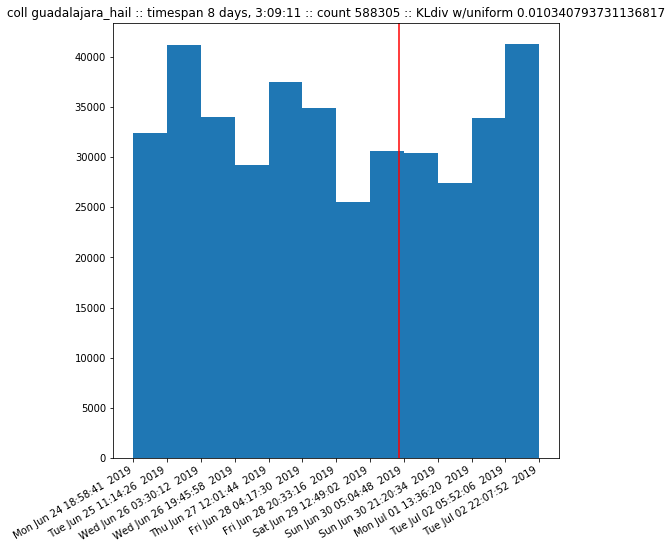

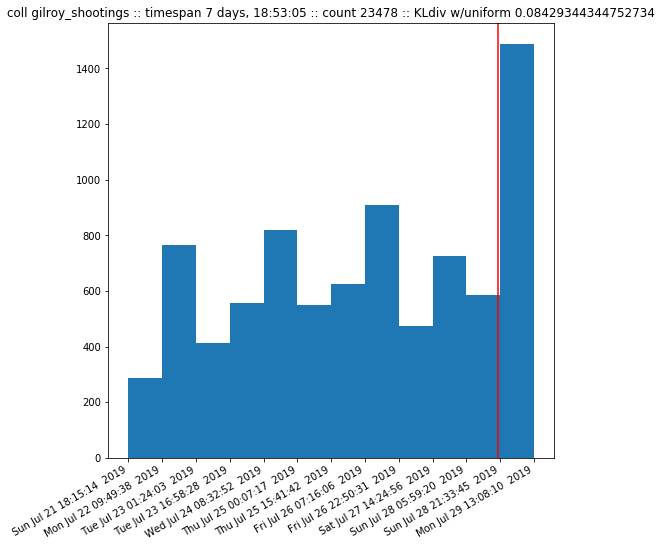

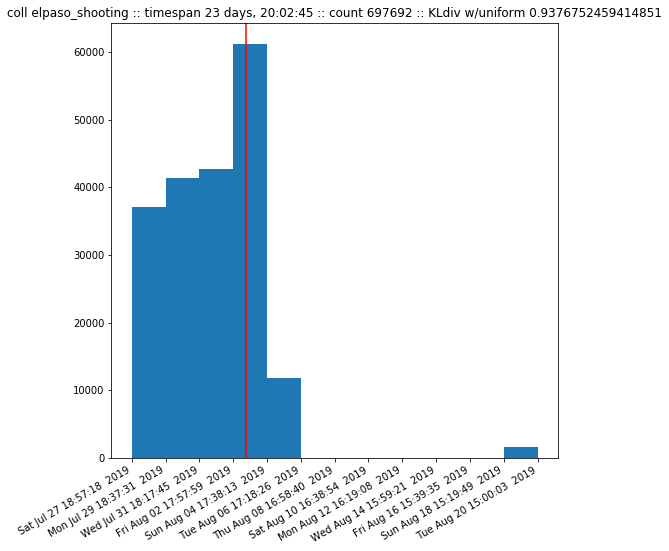

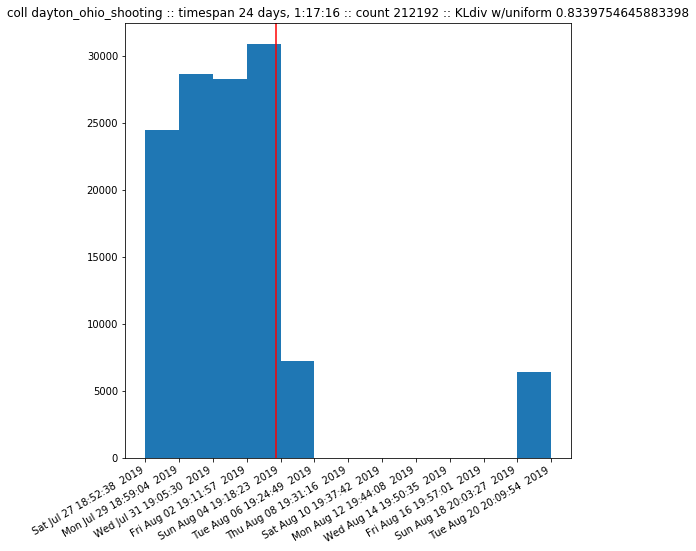

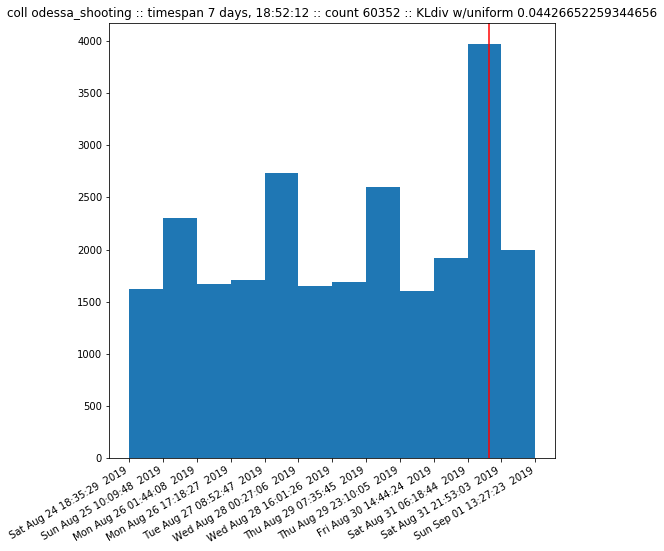

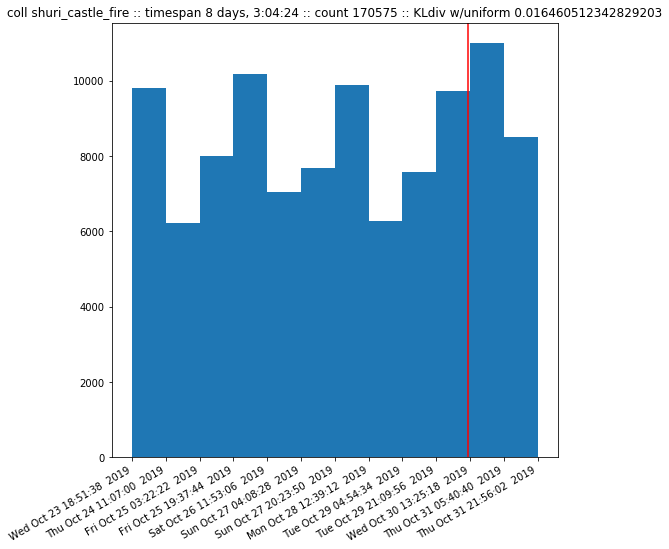

In [16]:
BINS=12
for j in range(len(data_collections)):
    fig = plt.figure()
    times = np.array(list(map(lambda x: x.timestamp(), coll_dates[j])))
    bins, ticks, hist = plt.hist(times, bins=BINS)
    plt.axvline(ground_truth_labels[j].timestamp(), c='r')
    min_time = np.min(times)
    time_range = np.max(times) - min_time
    time_bin_w = time_range/BINS
    time_bins = [min_time + i*time_bin_w for i in range(BINS+1)] 
    plt.xticks(time_bins,
        [strftime(datetime.datetime.fromtimestamp(time_bin)) for time_bin in time_bins], 
        rotation=30, ha="right")
    plt.title("coll {} :: timespan {} :: count {} :: KLdiv w/uniform {}".format(
        data_collections[j], 
        str(dates[j][1] - dates[j][0]), 
        db[data_collections[j]].count(),
        scipy.stats.entropy(bins, np.ones_like(bins))))

In [17]:
bins/np.sum(bins)

array([0.09632181, 0.06103162, 0.07861783, 0.09977625, 0.06915739,
       0.07552651, 0.09705784, 0.06149287, 0.07424091, 0.09536988,
       0.10792165, 0.08348545])

In [19]:
def remove_by_regex(text, regexp):
    return regexp.sub("", text)

url_re = re.compile(r"http.?://[^\s]+[\s]?")
def remove_urls(text):
    return remove_by_regex(text, url_re)

specialchar_re = re.compile("[" + ''.join(map(re.escape, 
    [",", ":", "\"", "=", "&", ";", "%", "$", "@", "%", "^", "*", "(", ")", "{", "}",
     "[", "]", "|", "/", "\\", ">", "<", "-", "!", "?", ".", "'", "--", "---"])) + "]")
def remove_special_chars(text):
    return remove_by_regex(text, specialchar_re)

username_re = re.compile(r"@[^\s]+[\s]?")
def remove_usernames(text):
    return remove_by_regex(text, username_re)

number_re = re.compile(r"\s?[0-9]+\.?[0-9]*")
def remove_numbers(text):
    return remove_by_regex(text, number_re)
    
def lower(text):
    return text.lower()

cleanup = (remove_urls,
           remove_usernames,
           remove_special_chars,
           remove_numbers,
           lower)

In [20]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 

In [21]:
tknzr.tokenize(db[data_collections[0]].find_one({"retweeted_status":{"$exists":False}})["text"])

['It', 'would', 'seem', 'a', 'shame', 'to', 'buck', 'tradition', '.']

In [22]:
def get_cikm_tweet_column(line):
    try:
        return line.split("\t")[-2]
    except Exception as e:
        return None
def count(iterable, item):
    tot = 0
    for i in iterable:
        if i == item:
            tot += 1
    return tot

In [25]:
db[coll].find_one({"retweeted_status":{"$exists":False}}, projection=['created_at', 'text', 'id'])

{'_id': ObjectId('5dbaedccdd069701dd1a7945'),
 'created_at': 'Wed Oct 23 23:59:56 +0000 2019',
 'id': 1187156733002543104,
 'text': '@pudra_marina 漢字を覚えるのは\n日本人でも難しいですし\n読めない漢字、読めても書けない漢字、知っているけど使い所がよく分からない、読めるけど意味がよく分からない文字等たくさんあります✩\n\n覚えてもしばらくその文字に触… https://t.co/CjqijcSYO0'}

In [32]:
shootings_tweets = []
projection = ['id', 'created_at', 'text']
for coll in [c for c in data_collections if "shooting" in c]:
    shootings_tweets.extend(list(map(lambda x: [coll, x['id'], strptime(x['created_at']).timestamp(), x['text']], 
             db[coll].find({"retweeted_status":{"$exists":False}}, projection=projection)))
    )

In [35]:
shootings_tweets[::10000]

[['christchurch_shooting',
  1103806883918303233,
  1552003043.0,
  '@beckeleven It would seem a shame to buck tradition.'],
 ['christchurch_shooting',
  1105770210609389569,
  1552471137.0,
  '@HeyRayShipley I need it. Except perhaps in a very nice log cabin.'],
 ['poway_shooting',
  1120158366062432261,
  1555901540.0,
  'Just found out Americans call cornbread “yee yee shuck loaves” LOL!'],
 ['poway_shooting',
  1121760105190567937,
  1556283425.0,
  'Crash cleared to the right shoulder in #UniversityCity on 805 SB at Miramar Rd, stopped traffic back to Mira Mesa Blvd, delay of 9 mins'],
 ['highlands_ranch_shooting',
  1123386964625879046,
  1556671298.0,
  'BRIDGING THE GAP BETWEEN THROWING AND REHAB\nhttps://t.co/yIvNMue6ko\n\n@BHPrehab https://t.co/AxhC5pOJL5'],
 ['highlands_ranch_shooting',
  1124059004228067328,
  1556831525.0,
  'Still working on his defense https://t.co/99R55x9vmz'],
 ['highlands_ranch_shooting',
  1124775855077646336,
  1557002435.0,
  '@psaundersdp https://

In [38]:
shootings_tweets_df = pd.DataFrame(shootings_tweets, columns=["collection", "tweet_id", "timestamp", "text"])

In [46]:
shootings_tweets_df

,collection,tweet_id,timestamp,text
0,christchurch_shooting,1103806883918303233,1.552003e+09,@beckeleven It would seem a shame to buck trad...
1,christchurch_shooting,1103806723549290496,1.552003e+09,"Ou é só eu, ou não é eu 🙅🏾‍♀️"
2,christchurch_shooting,1103806649037336576,1.552003e+09,We are so lucky to have Debbie @DebMunro_Autho...
3,christchurch_shooting,1103806431478853632,1.552003e+09,Escaping Poverty Requires Almost 20 Years With...
4,christchurch_shooting,1103806416643534848,1.552003e+09,Thank you to a person in South Bend! 😆😆🎧😀 htt...
5,christchurch_shooting,1103806197084422144,1.552003e+09,"Principal's Pen - Term 1 - Week 7, 2019 https:..."
6,christchurch_shooting,1103806142256476160,1.552003e+09,https://t.co/CwzyCqsu4D
7,christchurch_shooting,1103806129178472448,1.552003e+09,"お昼は15.2NZドル（約1,150円）のバーガー。味を考えるとやっぱり割高。\n#ニュージ..."
8,christchurch_shooting,1103805953261125632,1.552003e+09,Can you believe this guy is coming to town?! W...
9,christchurch_shooting,1103805937200988160,1.552003e+09,@DrMatthewSweet https://t.co/8jl0WsErM6


In [39]:
shootings_tweets_df.head()

,collection,tweet_id,timestamp,text
0,christchurch_shooting,1103806883918303233,1.552003e+09,@beckeleven It would seem a shame to buck trad...
1,christchurch_shooting,1103806723549290496,1.552003e+09,"Ou é só eu, ou não é eu 🙅🏾‍♀️"
2,christchurch_shooting,1103806649037336576,1.552003e+09,We are so lucky to have Debbie @DebMunro_Autho...
3,christchurch_shooting,1103806431478853632,1.552003e+09,Escaping Poverty Requires Almost 20 Years With...
4,christchurch_shooting,1103806416643534848,1.552003e+09,Thank you to a person in South Bend! 😆😆🎧😀 htt...


In [44]:
shootings_tweets_df.to_csv(os.path.join(root_dir, "shootings_tweets.csv"), index=False)

In [45]:
pd.read_csv(os.path.join(root_dir, "shootings_tweets.csv")).head()

,collection,tweet_id,timestamp,text
0,christchurch_shooting,1103806883918303233,1.552003e+09,@beckeleven It would seem a shame to buck trad...
1,christchurch_shooting,1103806723549290496,1.552003e+09,"Ou é só eu, ou não é eu 🙅🏾‍♀️"
2,christchurch_shooting,1103806649037336576,1.552003e+09,We are so lucky to have Debbie @DebMunro_Autho...
3,christchurch_shooting,1103806431478853632,1.552003e+09,Escaping Poverty Requires Almost 20 Years With...
4,christchurch_shooting,1103806416643534848,1.552003e+09,Thank you to a person in South Bend! 😆😆🎧😀 htt...
